In [20]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

# DATASET PREPARING

In [2]:
# Wczytanie danych z pliku
save_path = "dataset.npz"
data = np.load(save_path)

# Odczytaj macierze X i y
X= data['X']
y = data['y']

actions = np.array(['hello', 'thankyou', 'love', 'friend', 'good', 'meet', 'you', 'think', 'bed', 'have'])


In [3]:
from sklearn.model_selection import train_test_split


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)



In [4]:
X_train.shape

(210, 30, 1662)

In [5]:
y_train.shape

(210, 10)

In [6]:
X_validation.shape

(45, 30, 1662)

# GRU

In [7]:

model = tf.keras.Sequential([

    tf.keras.layers.GRU(units=128, input_shape=(30, 1662), return_sequences=True),

    tf.keras.layers.GRU(units=64, return_sequences=True),

    tf.keras.layers.GRU(units=32, return_sequences=True),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128),

    tf.keras.layers.Dense(64),

    tf.keras.layers.Dense(10, activation='softmax') 
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


num_epochs = 100
batch_size = 13

history_gru = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(X_validation, y_validation))

model.save_weights('gru_weights.h5')



Epoch 1/100
17/17 [==============================] - 28s 392ms/step - loss: 2.3528 - accuracy: 0.1048 - val_loss: 2.3799 - val_accuracy: 0.1556
Epoch 2/100
17/17 [==============================] - 2s 129ms/step - loss: 2.2450 - accuracy: 0.1095 - val_loss: 2.1842 - val_accuracy: 0.2000
Epoch 3/100
17/17 [==============================] - 2s 134ms/step - loss: 2.0649 - accuracy: 0.3238 - val_loss: 1.9560 - val_accuracy: 0.4222
Epoch 4/100
17/17 [==============================] - 2s 131ms/step - loss: 1.7948 - accuracy: 0.3333 - val_loss: 1.6863 - val_accuracy: 0.2889
Epoch 5/100
17/17 [==============================] - 2s 137ms/step - loss: 1.6142 - accuracy: 0.4000 - val_loss: 1.4831 - val_accuracy: 0.4889
Epoch 6/100
17/17 [==============================] - 3s 146ms/step - loss: 1.4029 - accuracy: 0.4762 - val_loss: 1.3668 - val_accuracy: 0.4889
Epoch 7/100
17/17 [==============================] - 3s 160ms/step - loss: 1.3202 - accuracy: 0.5000 - val_loss: 1.2372 - val_accuracy: 0.511

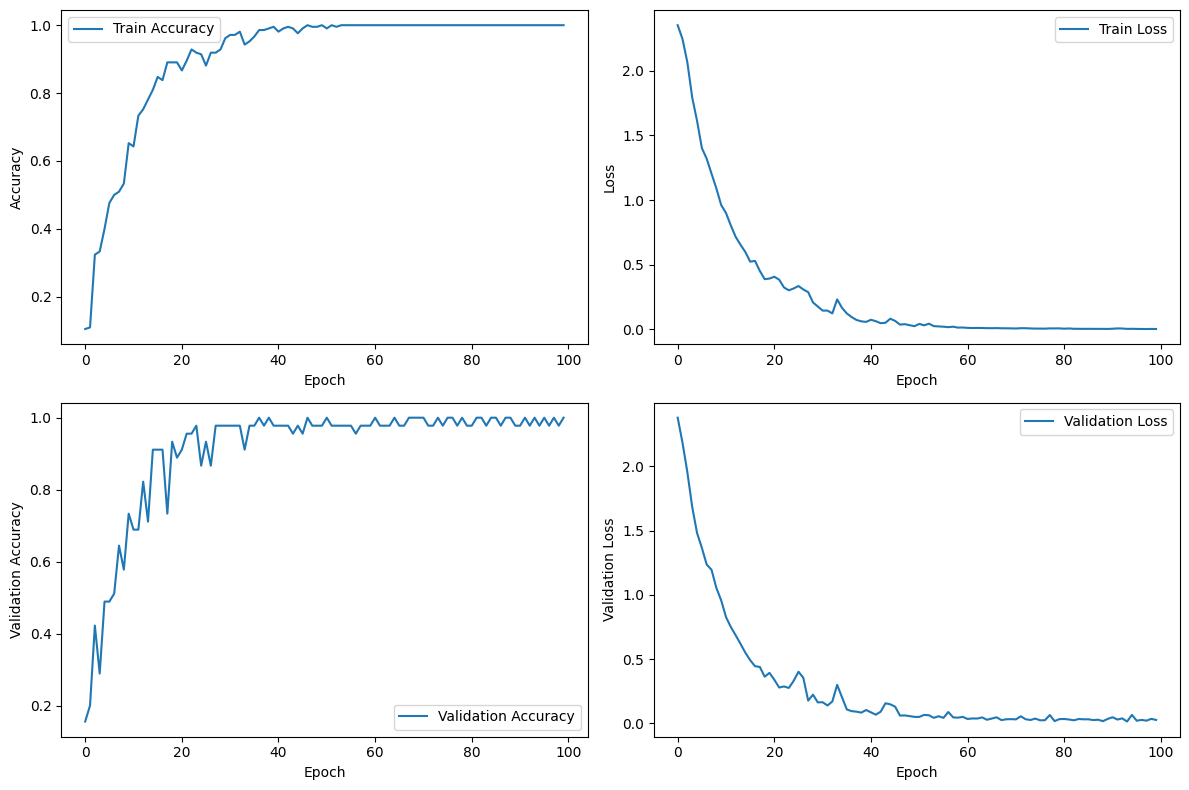

In [8]:
import matplotlib.pyplot as plt


# Wyświetlanie wykresów
plt.figure(figsize=(12, 8))

# Wykres dokładności trenowania
plt.subplot(2, 2, 1)
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Wykres straty trenowania
plt.subplot(2, 2, 2)
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Wykres dokładności walidacji
plt.subplot(2, 2, 3)
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

# Wykres straty walidacji
plt.subplot(2, 2, 4)
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score


y_pred = model.predict(X_test)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = np.argmax(y_test, axis=1)

confusion = confusion_matrix(y_true_labels, y_pred_labels)

print("Macierz konfuzji:")
print(confusion)

print(accuracy_score(y_pred_labels, y_true_labels))

2/2 [==============================] - 4s 33ms/step
Macierz konfuzji:
[[4 0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [1 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 6]]
0.9777777777777777


In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_fscore_support

y_pred = model.predict(X_test)  


y_true = np.argmax(y_test, axis=1)  
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true, y_pred)



precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

for i in range(len(precision)):
    print(f'Label {i} - Accuracy: {accuracy}, Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}')

2/2 [==============================] - 0s 41ms/step
Label 0 - Accuracy: 0.9777777777777777, Precision: 0.8, Recall: 1.0, F1-Score: 0.888888888888889
Label 1 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 2 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 3 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 4 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 5 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 6 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 7 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 8 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 0.5, F1-Score: 0.6666666666666666
Label 9 - Accuracy: 0.9777777777777777, Precision: 1.0, Recall: 1.0, F1-Score: 1.0


8/8 [==============================] - 0s 25ms/step
Average cross-validation accuracy (k=5): 0.9533333333333331 a dla pojedycznych k: [0.9666666666666667, 0.95, 0.9333333333333333, 0.9166666666666666, 1.0]
Average difference between training and validation accuracy: 0.046666666666666676


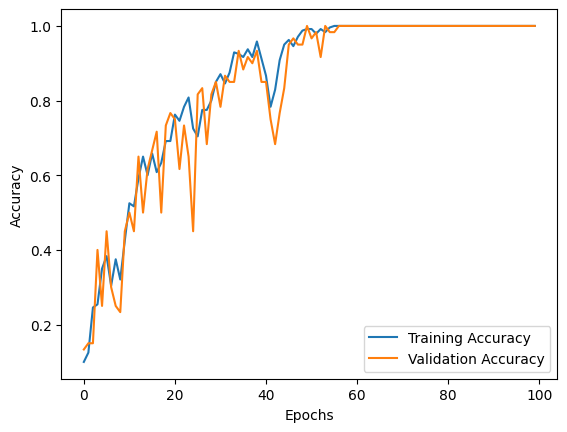

In [11]:
#kfolds
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Flatten
import matplotlib.pyplot as plt

k = 5

kf = KFold(n_splits=k, shuffle=True)


accuracies = []
train_accuracies = []
val_accuracies = []

for train_index, val_index in kf.split(X):

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    model = Sequential()
    model.add(GRU(units=128, input_shape=(30, 1662), return_sequences=True))
    model.add(GRU(units=64, return_sequences=True))
    model.add(GRU(units=32, return_sequences=True))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(actions.shape[0], activation='softmax'))

    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    history_gru = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)

    y_pred = model.predict(X_val)

    accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
    accuracies.append(accuracy)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
    train_accuracies.append(train_accuracy)

    val_accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
    val_accuracies.append(val_accuracy)


mean_accuracy = np.mean(accuracies)
print(f'Average cross-validation accuracy (k={k}): {mean_accuracy} a dla pojedycznych k: {accuracies}')

differences = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]
mean_difference = np.mean(differences)
print(f'Average difference between training and validation accuracy: {mean_difference}')

plt.plot(history_gru.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history_gru.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# LSTM

In [12]:
# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape=(30, 1662)))
# model.add(Dropout(0.2))  # Dropout dla regularyzacji
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(128, return_sequences=False))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
# model.add(Dropout(0.5))  # Dodaj Dropou
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
# model.add(Dropout(0.5))  # Dodaj Dropout
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(Dropout(0.5))  # Dodaj Dropout
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dropout(0.5))  # Dodaj Dropout
# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



# model = Sequential()
# model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
# model.add(LSTM(128, return_sequences=True, activation='relu'))
# model.add(LSTM(64, return_sequences=False, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(actions.shape[0], activation='softmax'))
# model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



lstm = model.fit(X_train, y_train, epochs=100, validation_data=(X_validation, y_validation))

Epoch 1/100
8/8 [==============================] - 5s 125ms/step - loss: 7.5500 - categorical_accuracy: 0.1167 - val_loss: 2.2726 - val_categorical_accuracy: 0.1333
Epoch 2/100
8/8 [==============================] - 0s 42ms/step - loss: 2.3462 - categorical_accuracy: 0.0958 - val_loss: 2.2175 - val_categorical_accuracy: 0.2000
Epoch 3/100
8/8 [==============================] - 0s 44ms/step - loss: 2.1877 - categorical_accuracy: 0.1417 - val_loss: 2.0377 - val_categorical_accuracy: 0.1556
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 2.0895 - categorical_accuracy: 0.1333 - val_loss: 1.9170 - val_categorical_accuracy: 0.2222
Epoch 5/100
8/8 [==============================] - 0s 40ms/step - loss: 2.0965 - categorical_accuracy: 0.1500 - val_loss: 1.9608 - val_categorical_accuracy: 0.1333
Epoch 6/100
8/8 [==============================] - 0s 40ms/step - loss: 1.9601 - categorical_accuracy: 0.2167 - val_loss: 1.8328 - val_categorical_accuracy: 0.2222
Epoch 7/100
8/8

In [13]:
model.save_weights('lstm_weights.h5')

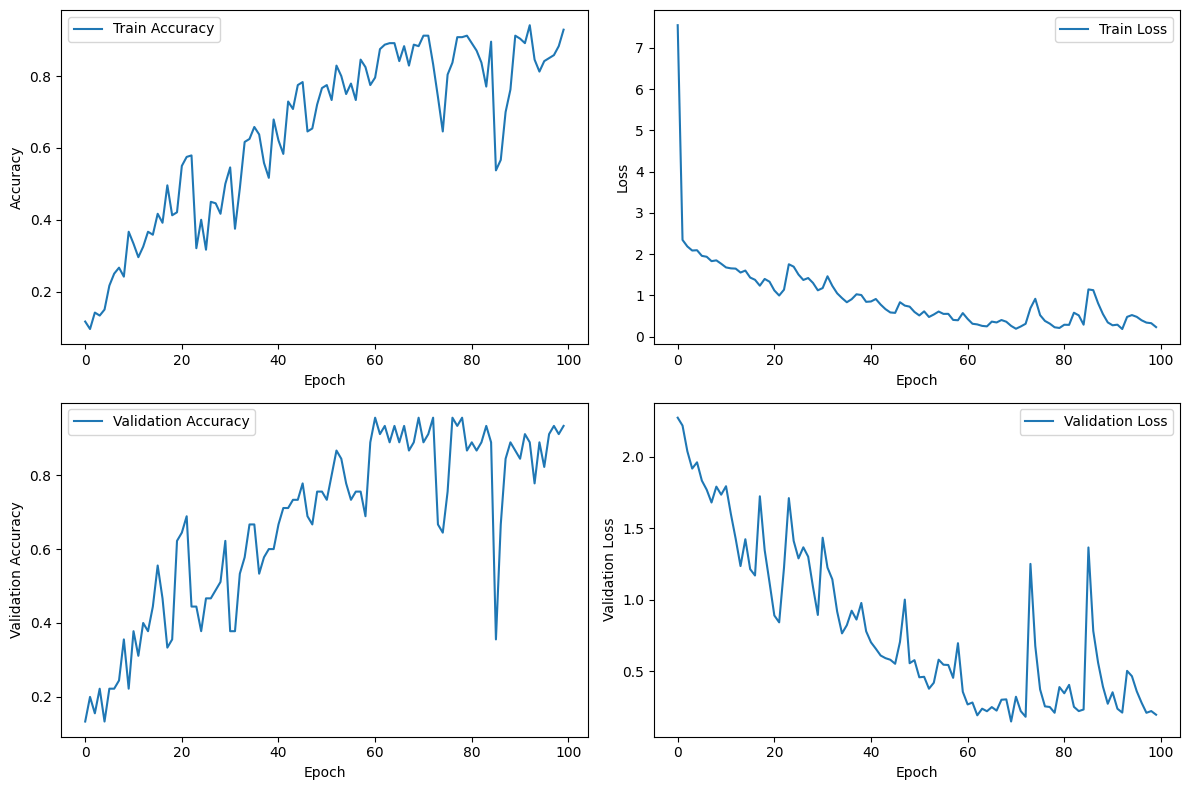

In [14]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))


plt.subplot(2, 2, 1)
plt.plot(lstm.history['categorical_accuracy'], label='Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(2, 2, 2)
plt.plot(lstm.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.subplot(2, 2, 3)
plt.plot(lstm.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(lstm.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix, accuracy_score
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
print(confusion_matrix(ytrue, yhat))
accuracy_score(ytrue, yhat)

2/2 [==============================] - 0s 11ms/step
[[3 0 0 0 0 0 0 1 0 0]
 [0 2 0 0 0 2 0 0 0 0]
 [0 0 7 0 0 0 0 0 0 0]
 [0 0 0 6 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0]
 [0 0 0 0 0 0 0 7 0 0]
 [0 0 0 0 0 0 0 0 2 0]
 [0 0 0 1 0 0 0 0 0 5]]


0.9111111111111111

In [16]:
y_pred = model.predict(X_test)  


y_true = np.argmax(y_test, axis=1)  
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_true, y_pred)


from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Wyniki dla każdej etykiety
for i in range(len(precision)):
    print(f'Label {i} - Accuracy: {accuracy}, Precision: {precision[i]}, Recall: {recall[i]}, F1-Score: {f1[i]}')

2/2 [==============================] - 0s 0s/step
Label 0 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 0.75, F1-Score: 0.8571428571428571
Label 1 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 0.5, F1-Score: 0.6666666666666666
Label 2 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 3 - Accuracy: 0.9111111111111111, Precision: 0.8571428571428571, Recall: 1.0, F1-Score: 0.923076923076923
Label 4 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 5 - Accuracy: 0.9111111111111111, Precision: 0.7142857142857143, Recall: 1.0, F1-Score: 0.8333333333333333
Label 6 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 7 - Accuracy: 0.9111111111111111, Precision: 0.875, Recall: 1.0, F1-Score: 0.9333333333333333
Label 8 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 1.0, F1-Score: 1.0
Label 9 - Accuracy: 0.9111111111111111, Precision: 1.0, Recall: 0.8333333333333334, F1-Score: 0.

kfolds

8/8 [==============================] - 0s 12ms/step
Średnia dokładność walidacji krzyżowej (k=5): 0.9633333333333333 a całość [0.9, 0.95, 1.0, 1.0, 0.9666666666666667]
Średnia różnica między treningową a walidacyjną dokładnością: nan


c:\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Python311\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


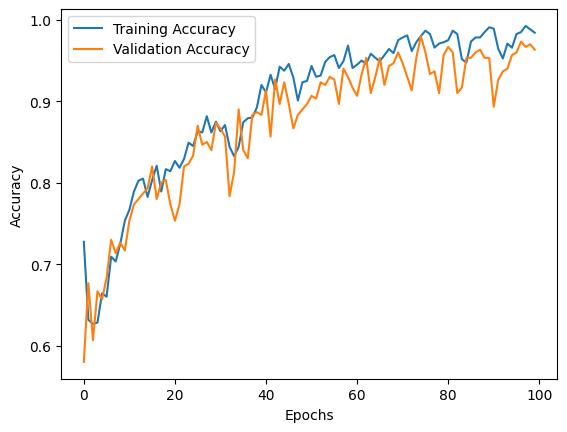

In [19]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization
import matplotlib.pyplot as plt


k = 5

kf = KFold(n_splits=k, shuffle=True)

accuracies = []
train_accuracies = []
val_accuracies = []
histories = [] 


model = Sequential()
model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # model = Sequential()
    # model.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 1662)))
    # model.add(LSTM(128, return_sequences=True, activation='relu'))
    # model.add(LSTM(64, return_sequences=False, activation='relu'))
    # model.add(Dense(32, activation='relu'))
    # model.add(Dense(actions.shape[0], activation='softmax'))    
    # model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


    history_lstm = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)
    histories.append(history_lstm)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))
    accuracies.append(accuracy)

    train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(model.predict(X_train), axis=1))
    train_accuracies.append(train_accuracy)

mean_accuracy = np.mean(accuracies)
print(f'Średnia dokładność walidacji krzyżowej (k={k}): {mean_accuracy} a całość {accuracies}')

differences = [train_acc - val_acc for train_acc, val_acc in zip(train_accuracies, val_accuracies)]
mean_difference = np.mean(differences)
print(f'Średnia różnica między treningową a walidacyjną dokładnością: {mean_difference}')

avg_history = {}
for key in histories[0].history.keys():
    avg_history[key] = np.mean([fold.history[key] for fold in histories], axis=0)

plt.plot(avg_history['categorical_accuracy'], label='Training Accuracy')
plt.plot(avg_history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
